<a href="https://colab.research.google.com/github/satomin0718/pictresize/blob/main/detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 物体検出
YOLO(You Only Look Once)というアルゴリズムを用いて画像認識を行う。その際に計算量が大きくなるため、並列・分散処理やC/C++への変換を適宜行う。

### 下準備

In [ ]:
!pip install dask --upgrade
# dask : 並列・分散処理をしてくれるライブラリをインストール。
# つまり大きなデータセットを快適に扱えるようにする。

     |████████████████████████████████| 901kB 19.0MB/s 
  Found existing installation: dask 2.12.0
    Uninstalling dask-2.12.0:
      Successfully uninstalled dask-2.12.0


In [ ]:
ls

sample_data/


In [ ]:
!pip install Cython
# Cython : Python を C/C++ に変換してくれるライブラリ。
# これにより計算のスピードが上がる

In [ ]:
!git clone https://github.com/pjreddie/darknet
# darknet : C言語で書かれたニューラルネットフレームワーク そちらをclone

Cloning into 'darknet'...
remote: Enumerating objects: 5931, done.
remote: Total 5931 (delta 0), reused 0 (delta 0), pack-reused 5931
Receiving objects: 100% (5931/5931), 6.34 MiB | 31.39 MiB/s, done.
Resolving deltas: 100% (3922/3922), done.


In [ ]:
cd darknet/

/content/darknet


##### YOLO のコンパイル
YOLOは物体検出アルゴリズム。物体と背景の区別ができる。これによって画像から物体が含まれている領域を判断してくれる。

In [ ]:
!make

mkdir -p obj
mkdir -p backup
mkdir -p results
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/gemm.c -o obj/gemm.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/utils.c -o obj/utils.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/cuda.c -o obj/cuda.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/deconvolutional_layer.c -o obj/deconvolutional_layer.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/convolutional_layer.c -o obj/convolutional_layer.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/list.c -o obj/list.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/image.c -o obj/image.o
gcc 

In [ ]:
!wget https://pjreddie.com/media/files/yolov3.weights

--2021-02-21 17:26:45--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  42.9MB/s    in 5.8s    

2021-02-21 17:26:52 (40.5 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



### 物体検出デモ

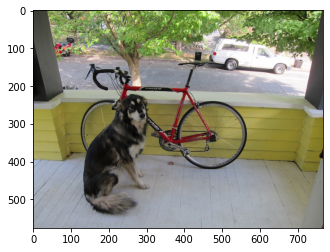

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

im = Image.open("data/dog.jpg")
plt.imshow(im)
#表示
plt.show()

# 画像の読み込み。今回はYOLOにテストデータとして用意されている犬と自転車とトラックの写真を使用します。
# 上の方でロードしているのは画像を表示するときに必要なツール

In [ ]:
! ./darknet detect cfg/yolov3.cfg yolov3.weights data/dog.jpg
# YOLOでの物体検出。大量の計算を行うので時間がかかります。しばし待ちましょう。

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8                 152 x 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

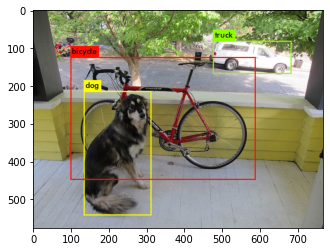

In [ ]:
# 結果画像の読み込み
im = Image.open("predictions.jpg")

plt.imshow(im)
plt.grid(False)
#表示
plt.show()

#### 自分の写真で挑戦

まずは使う画像を作業ディレクトリに移します。
darknet -> data の中に画像(.jpg)をドラッグしてきてください。

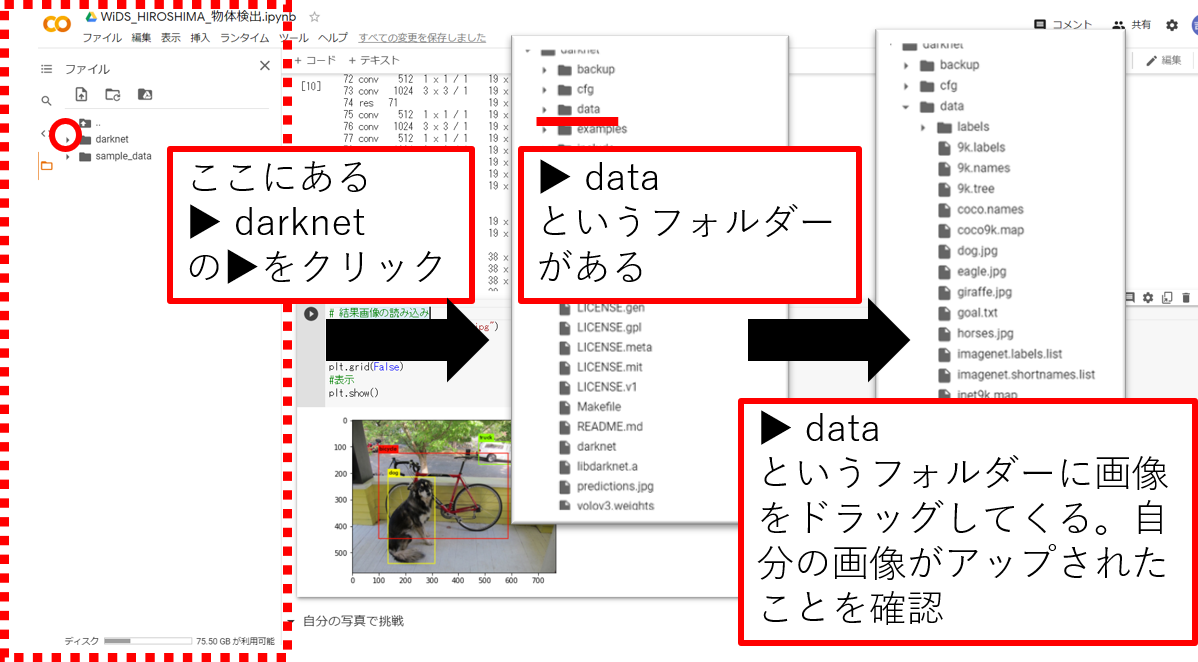

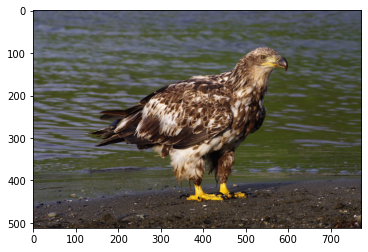

In [ ]:
#画像の読み込み。*自分で用意した画像の名前* を消して、そこに自分の画像ファイルの名前を書きます。
my_photo = Image.open("data/eagle.jpg")
plt.imshow(my_photo)
#表示
plt.show()

In [ ]:
! ./darknet detect cfg/yolov3.cfg yolov3.weights data/eagle.jpg
# *自分で用意した画像の名前* を消して、そこに自分の画像ファイルの名前を書きます。
# YOLOでの物体検出。大量の計算を行うので時間がかかります。しばし待ちましょう。

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8                 152 x 

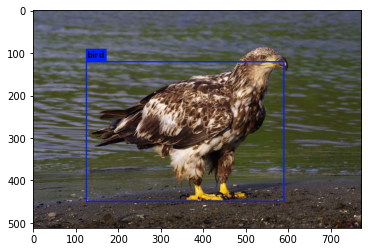

In [ ]:
# 結果画像の読み込み
my_photo_pred = Image.open("predictions.jpg")

plt.imshow(my_photo_pred)
plt.grid(False)
#表示
plt.show()

#### 結果画像のダウンロード

In [ ]:
from google.colab import files

files.download('predictions.jpg')
# download フォルダーに結果の画像が入っているはずです。

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>